# Hands-On NLP — Class 2

<span style="color:magenta">Group members:</span>

* Carlos Cuevas Villarmín
* Javier Alejandro Lopetegui González
* José Felipe Espinosa Orjuela

## Outline

- Embeddings from scratch

- Classifications with embeddings

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
#import pca
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

print("sklearn", sklearn.__version__)   # 1.3.2

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

sklearn 1.3.2


[nltk_data] Downloading package punkt to /home/carlos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [4]:
DATA = Path("../data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

## Getting the data

In [5]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology


woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nWhere did this story about stars being p...
woodworking,2461,6729416,Q:\n\nTool recommendation to prick bamboo node...
robotics,2981,7254006,Q:\n\nControlling a conveyor belt with a time ...
hsm,2329,7364214,"Q:\n\nWhen did Mathematics stop being one of ""..."
health,3412,9148631,Q:\n\nWhy doesn't the heart always pump at max...
portuguese,1840,4415251,"Q:\n\nQual a tradução correta de ""shipping add..."


### Tokenizing

In [6]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [7]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nWhere did this story about stars being p...,"[Q, :, Where, did, this, story, about, stars, ...",942611,51243
woodworking,2461,6729416,Q:\n\nTool recommendation to prick bamboo node...,"[Q, :, Tool, recommendation, to, prick, bamboo...",1390534,32316
robotics,2981,7254006,Q:\n\nControlling a conveyor belt with a time ...,"[Q, :, Controlling, a, conveyor, belt, with, a...",1526918,53823
hsm,2329,7364214,"Q:\n\nWhen did Mathematics stop being one of ""...","[Q, :, When, did, Mathematics, stop, being, on...",1445136,62465
health,3412,9148631,Q:\n\nWhy doesn't the heart always pump at max...,"[Q, :, Why, does, n't, the, heart, always, pum...",1714930,66007
portuguese,1840,4415251,"Q:\n\nQual a tradução correta de ""shipping add...","[Q, :, Qual, a, tradução, correta, de, ``, shi...",907253,60276


## Vectorization

### 🚧 TODO: How to vectorize text?

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [8]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)

wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df.tokens.map(lambda x:x.count(w))


In [9]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


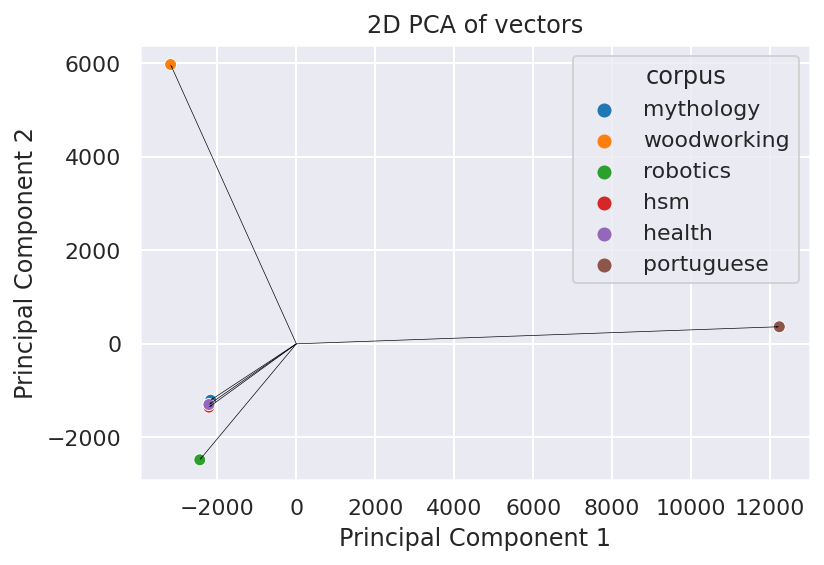

In [10]:
pca_model = PCA(n_components=2, random_state=42)
wc_df_pca = pca_model.fit_transform(wc_df)

sns.scatterplot(x=wc_df_pca[:, 0], y=wc_df_pca[:, 1], hue=wc_df.index, legend='full')
plt.quiver(np.zeros(6), np.zeros(6), wc_df_pca[:, 0], wc_df_pca[:, 1], angles='xy', scale_units='xy', scale=1, width = 0.001)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors')
plt.grid(True)
plt.show()


In terms of the first two principal components we can see that corpus woodworking and portuguese are very different from the other categories we have which are more similar to each other (a slightly difference in robotics corpus). 

#### Bag of words

### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    Try with and without the n-gram parameter

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

#### First with a toy example

In [11]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

With the whole vocabulary

In [12]:
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(xs.toarray())

vectorizer_2g = CountVectorizer(analyzer='word', ngram_range=(2,2))
x2gs = vectorizer_2g.fit_transform(corpus)

print(vectorizer_2g.get_feature_names_out())
print(x2gs.toarray())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [13]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first,is,one,second,the,third,this
0,This is the first document.,0,1,1,1,0,0,1,0,1
1,This document is the second document.,0,2,0,1,0,1,1,0,1
2,And this is the third one.,1,0,0,1,1,0,1,1,1
3,Is this the first document?,0,1,1,1,0,0,1,0,1


With a subset of the vocabulary

In [14]:
vocabulary = ["and", "document", "first"]
vectorizer = CountVectorizer(vocabulary=vocabulary)
x_fix_voc = vectorizer.fit_transform(corpus)

x_fix_voc_df = pd.DataFrame(x_fix_voc.toarray(), columns=vectorizer.get_feature_names_out())
x_fix_voc_df.insert(0, "Document", corpus)
x_fix_voc_df

,Document,and,document,first
0,This is the first document.,0,1,1
1,This document is the second document.,0,2,0
2,And this is the third one.,1,0,0
3,Is this the first document?,0,1,1


#### Reprocess the stackoverflow corpora with `CountVectorizer`

In [15]:
vectorizer = CountVectorizer(vocabulary=words)

wc_cv = pd.DataFrame(index=df.index)
wc_cv = vectorizer.fit_transform(df.text)
wc_cv_df = pd.DataFrame(wc_cv.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
wc_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,867,75,6,307,35,4,23,4,0
woodworking,5,8017,1,19,16,0,53,0,0
robotics,0,22,5321,25,33,50,3,2,0
hsm,28,17,2,1513,1174,2095,39,7,0
health,55,13,1,242,263,9,2178,4,0
portuguese,2,13,3,18,7,3,9,1061,0


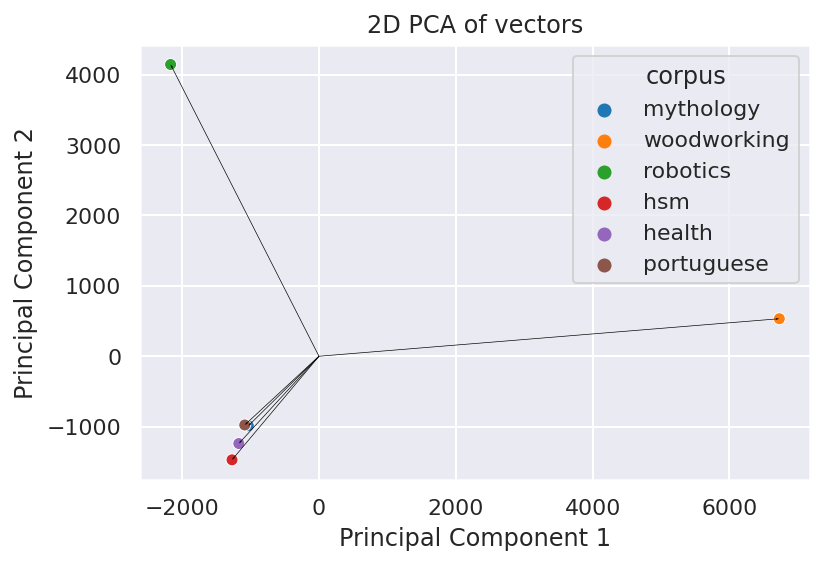

In [16]:
pca_model_cv = PCA(n_components=2, random_state=42)
wc_df_pca_cv = pca_model_cv.fit_transform(wc_cv_df)

sns.scatterplot(x=wc_df_pca_cv[:, 0], y=wc_df_pca_cv[:, 1], hue=wc_cv_df.index, legend='full')
plt.quiver(np.zeros(6), np.zeros(6), wc_df_pca_cv[:, 0], wc_df_pca_cv[:, 1], angles='xy', scale_units='xy', scale=1, width = 0.001)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors')
plt.grid(True)
plt.show()

With the CountVectorizer tool we obtain different results. This time robotics and woodworking are the most differenciated corpus while the others are more similar to each other in terms of the first two principal components.

#TODO: Put labels for each point to analize whic datasets are more similar

### 🚧 TODO: Why is this different? 

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

In [17]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth wood robot history science mathematics health portuguese o"
)

# freqs = ...

# test_wc_df = ...

In [18]:
# test_xs = vectorizer...

# test_cv_df = ...

### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

-----------

### Now let's hold the corpus as individual documents

In [19]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [20]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df.head()

,text,category,cat_id
id,,,
mythology.stackexchange_0000000845,Q:\n\nWhere did this story about stars being p...,mythology,0
mythology.stackexchange_0000000653,Q:\n\nWhat happened to the flamines minores?\n...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000002081,Q:\n\nAre there any instances where non-Greco-...,mythology,0
mythology.stackexchange_0000000216,Q:\n\nHow does the Genius concept fit into the...,mythology,0


#### 🚧 TODO: Plot (bar) the number of documents per category

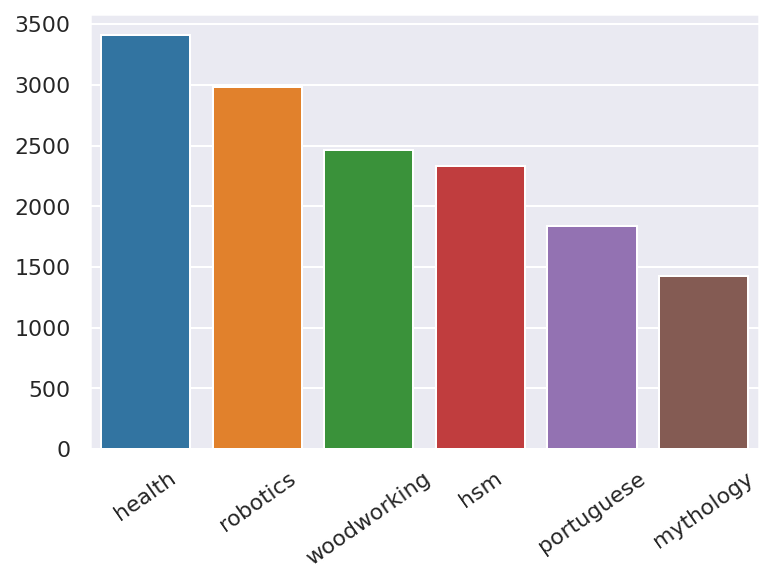

In [21]:
cat_count_df = doc_df['category'].value_counts()
sns.barplot(x=cat_count_df.index, y=list(cat_count_df))
plt.xticks(rotation=35)
plt.show()

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

  0%|          | 0/14451 [00:00<?, ?it/s]

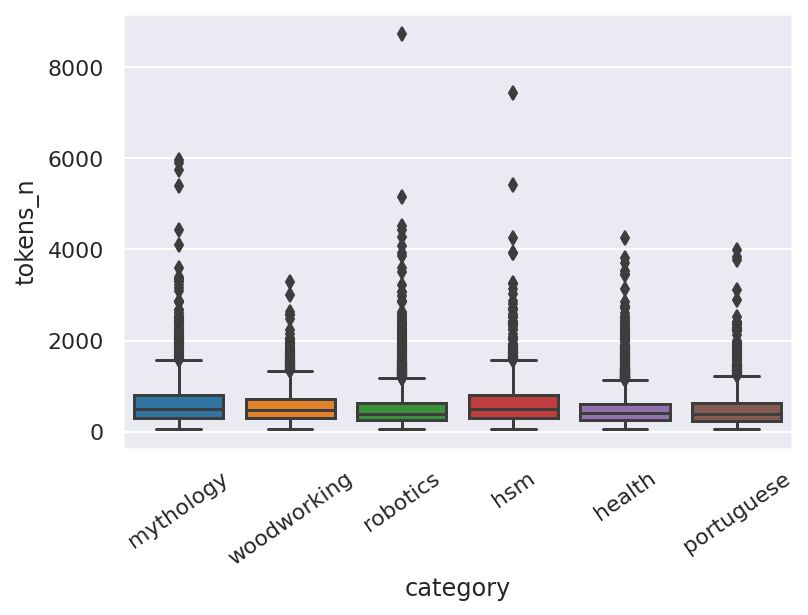

In [22]:
# Careful: slow!

doc_df["tokens_n"] = doc_df.text.progress_map(word_tokenize).map(len)
# boxplot with seaborn 
sns.boxplot(x="category", y="tokens_n", data=doc_df)
plt.xticks(rotation=35)
plt.show()

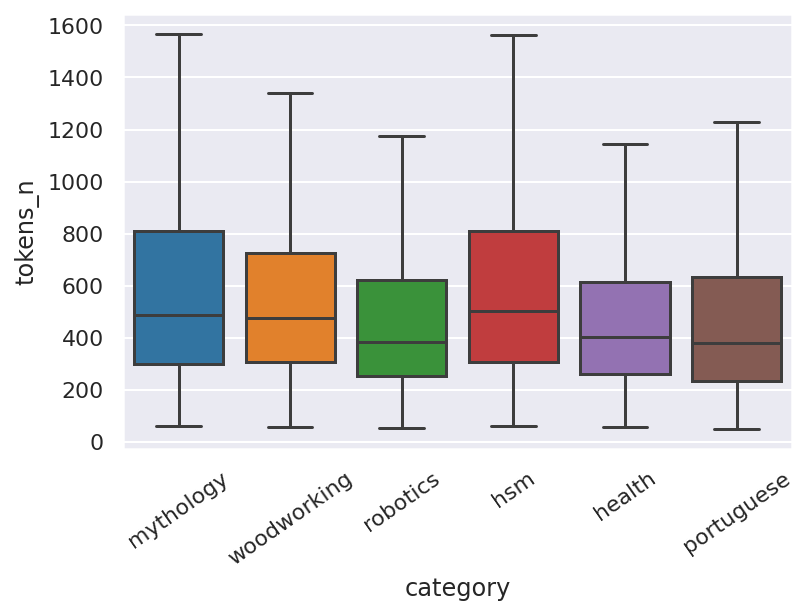

In [23]:
# plot without outliers
sns.boxplot(x= "category", y="tokens_n", data=doc_df, showfliers=False)
plt.xticks(rotation=35)
plt.show()

In [24]:
# analize the distribution of the number of tokens per category
desc_df = doc_df.groupby("category").tokens_n.describe()
desc_df["iqr"] = desc_df['75%'] - desc_df['25%']
desc_df["n_outliers"] = doc_df.groupby("category").apply(lambda x: len([1 for v in x['tokens_n'] if v < desc_df.loc[x.category.unique()[0], '25%'] - 1.5 * desc_df.loc[x.category.unique()[0], 'iqr'] or v > desc_df.loc[x.category.unique()[0], '75%'] + 1.5 * desc_df.loc[x.category.unique()[0], 'iqr']]))
desc_df["outliers_ratio"] = desc_df["n_outliers"] / desc_df["count"]
desc_df

,count,mean,std,min,25%,50%,75%,max,iqr,n_outliers,outliers_ratio
category,,,,,,,,,,,
health,3412.0,502.62,383.83,57.0,261.00,401.0,615.25,4246.0,354.25,196,0.06
hsm,2329.0,620.50,472.64,59.0,308.00,502.0,811.00,7443.0,503.00,81,0.03
mythology,1428.0,660.10,599.70,61.0,300.75,489.0,811.00,5967.0,510.25,88,0.06
portuguese,1840.0,493.08,399.38,48.0,232.00,378.5,631.75,3979.0,399.75,85,0.05
robotics,2981.0,512.22,461.11,53.0,252.00,385.0,622.00,8734.0,370.00,176,0.06
woodworking,2461.0,565.03,360.27,56.0,308.00,476.0,724.00,3276.0,416.00,98,0.04


We can see that there are some outliers in each category, specially in health, robotics and mythology (based on outliers_ratio). Before plotting the boxplot without outliers we cannot see graphically if the texts are significantly different in terms of length. Once the outliers are removed in the plot we can clearly see that the distribution of the text length is asymmetric.

Analyzing deeply the information provided by a box plot we can conclude that:
- The median value in all of the categories is lower than 500 (or approx equal), i.e., half of the texts of each category have a length lower than 500. For example in the case of portuguese half of the samples have a length lower than 379.
- In the plot, each box represent the area between the quantile 25 and 75. For the health, portuguese, robotics and woodworking we can see that the length of this area is between 354 and 416 what means that the distribution inside these quantiles is not very disperse. On the other side for hsm and mythology the distribution in this area is more disperse.
- However, if we look to the upper whisker we can clearly see that the length of texts have a more dispersed distribution considering samples with higher length than the median value.
- Additionally, the median value is closer to the quantile 25 than to the quantile 75 and the lower whisker is shorter. The distribution of the samples with lower text length than the median value is less dispersed.
Definetly, the length distribution is not symmetric and is more common to have texts of similar length if the length is lower than the median value.

#### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [25]:
longests_text = np.argmax(doc_df.tokens_n)
print(doc_df.text[longests_text])

Q:

6DOF Kinematics moveo

I asked on stackoverflow for the DH-Parameter for my robotic arm (moveo bcn3d).
I also copied the arduino code of Skyentific (YouTuber). Modified it to match my settings but i still does not work. Can someone please help me??? I am getting depressed if this keeps going like that.
In the home position, all joints have angle 0.
If I tell the forward kinematic that I want the 3rd joint and the 5th joint rotated 90 degrees, the values should be: (224, 0, 280) {x, y, z} should come out + some euler angles (can be ignored for now).
But I don't understand why these values come out, because the r and d values of the DH matrix are correct(https://stackoverflow.com/questions/67159164/denavit-hartenberg-6dof-moveo-inverse-kinematic-robot-arm?noredirect=1#comment118726837_67159164)
Output of the Arduino:\
inverse:
0.00
0.00
-0.00
-180.00
180.00
-180.00
forward:
-224.00
0.00
280.00
45.00
180.00
45.00
In this example you can see that the inverse kinematic calculates three 

**Why too large??**

We can explain the extremely large size of this text by its nature. In this case the user putted the entire code of its arduino implementation for a robotic arm movement system. It means that the tokenizer will find a lot of specific tokens for code and short tokens such as number and variables.

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict their number

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously 
  (only on the limited vocabulary)

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [26]:
ys = doc_df.cat_id.values

In [27]:
unconstrained_cv = CountVectorizer()
xs = unconstrained_cv.fit_transform(doc_df.text)

# print the number of features
print("N_features:", len(unconstrained_cv.get_feature_names_out()))

N_features: 153122


In [28]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text)
print("N_features:", len(cv.get_feature_names_out()))

N_features: 5000


In [29]:
pca = PCA(n_components=2, random_state=42)
xs_pca = pca.fit_transform(xs.toarray())

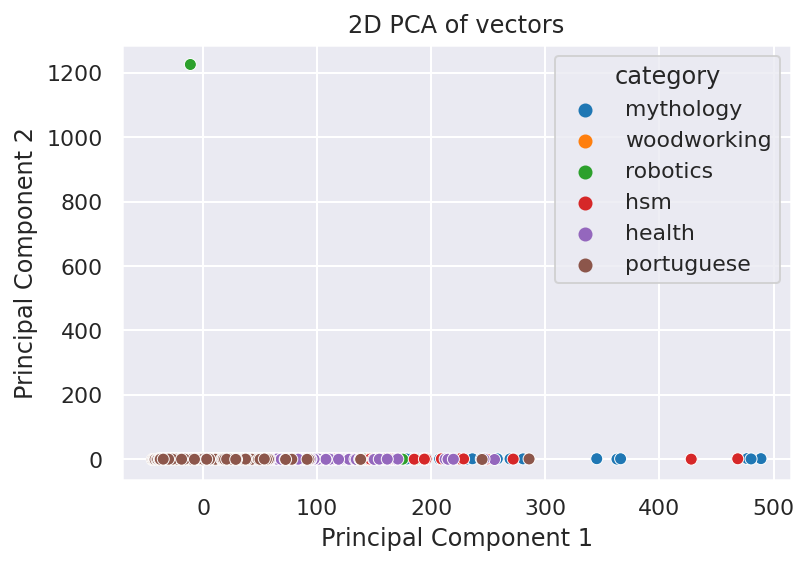

In [30]:
# scatter plot of the points
sns.scatterplot(x=xs_pca[:, 0], y=xs_pca[:, 1], hue=doc_df['category'], legend='full')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors')
plt.grid(True)
plt.show()


#### 🚧 TODO: Find that outlier!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

In [31]:
# find the outlier in pca scatter plot using pandas
outlier = doc_df.iloc[np.argmax(xs_pca[:, 1])]
print(outlier)
print(outlier.text)

text        Q:\n\narduino -lcd screen has weird noise with...
category                                             robotics
cat_id                                                      2
tokens_n                                                 2570
Name: robotics.stackexchange_0000005103, dtype: object
Q:

arduino -lcd screen has weird noise with multiple pictures

I'm connecting an arduino to a lcd screen using the following library. For the display code I have written a simple piece of code that should display 2 picture os eyes (1 angry one friendly) and switching at regular intervals, however the display keeps showing me weird pixels around the borders that shouldn't be there, by making it show the same eyes twice this can be fixed however as long as I have both eyes being used it runs into trouble. Here is my code: 
    void setup()
    {
      LCDA.initDriverPin(2,7,10); 
      LCDA.Initialise(); // INIT SCREEN  
      delay(100);
    }
    void loop(){
      LCDA.CLEAR(); //empty 

## What does it contain??

In this case the text correspond to a question about an arduino connected to a LCD display that apparently has too much unexpected noise. Then, most of the text correspond to hexagesimal numbers that represent pixels in the screen.

#### 🚧 TODO: The reason for this outlier is...

*   Give a short explanation

*   Remove the outlier from the dataframe 

*   Redo the dimensional reduction

*   Plot the 2D vectors and color them by category

In [32]:
out_tokens = cv.transform([outlier.text])
# get tokens more frequent in outlier than in the rest of the corpus
print(out_tokens.count_nonzero())
# print tokens non zero
print(cv.get_feature_names_out()[out_tokens.indices])
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][0]} appears {out_tokens[0, out_tokens.indices[0]]} times in the outlier text')
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][1]} appears {out_tokens[0, out_tokens.indices[1]]} times in the outlier text')
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][0]} appears {xs[:, out_tokens.indices[0]].sum()} times in the corpus')
print(f'The token {cv.get_feature_names_out()[out_tokens.indices][1]} appears {xs[:, out_tokens.indices[1]].sum()} times in the corpus')
print(f'The number of tokens in the outlier text is {out_tokens.sum()}')
print(f'The {(out_tokens[0, out_tokens.indices[0]] + out_tokens[0, out_tokens.indices[1]])/out_tokens.sum()} of the tokens in the outlier text are {cv.get_feature_names_out()[out_tokens.indices[0]]} or {cv.get_feature_names_out()[out_tokens.indices[1]]}')

147
['0x00' '0xfe' '10' '100' 'active' 'along' 'an' 'and' 'appear' 'arduino'
 'around' 'as' 'at' 'be' 'because' 'being' 'black' 'both' 'bottom' 'by'
 'byte' 'can' 'causing' 'changes' 'changing' 'clear' 'code' 'command'
 'connecting' 'creates' 'creating' 'cut' 'delay' 'different' 'display'
 'each' 'empty' 'even' 'eyes' 'face' 'few' 'finish' 'fit' 'fixed'
 'following' 'for' 'has' 'have' 'here' 'however' 'image' 'images' 'in'
 'intervals' 'into' 'is' 'it' 'just' 'keeps' 'kind' 'last' 'least'
 'library' 'lines' 'long' 'look' 'loop' 'making' 'me' 'memory' 'moving'
 'much' 'multiple' 'my' 'noise' 'not' 'note' 'of' 'on' 'one' 'ones' 'os'
 'other' 'out' 'patterns' 'picture' 'pictures' 'piece' 'problem'
 'problems' 'ran' 'random' 'rather' 're' 'regular' 'right' 'runs' 'same'
 'saved' 'screen' 'seconds' 'set' 'setup' 'should' 'shouldn' 'show'
 'showing' 'side' 'simple' 'size' 'so' 'solved' 'some' 'space' 'such'
 'suggesting' 'switching' 'that' 'the' 'them' 'themselves' 'then' 'there'
 'these' 't

We can clearly see from the results obtained in the last cell that this text is very different to the others. The tokens **0x00** and **0xfe** represent around the $84$ % of the tokens in this text which confirm our hypothesis of having most of the text defined by hexagesimal numbers. Furthermore, most of the appearances of these tokens are in this text, they just appear in the rest of the corpus 14 and 1 times respectively.

In [33]:
# drop the outlier from the doc_df
doc_df.drop(outlier.name, inplace=True)
len(doc_df) #To confirm that we have remove one text

14450

In [34]:
doc_df['category'].unique()

array(['mythology', 'woodworking', 'robotics', 'hsm', 'health',
       'portuguese'], dtype=object)

In [35]:
# pca over the data frame without the outlier
ys = doc_df.cat_id.values
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(doc_df.text)
pca = PCA(n_components=2, random_state=42)
xs_pca = pca.fit_transform(xs.toarray())

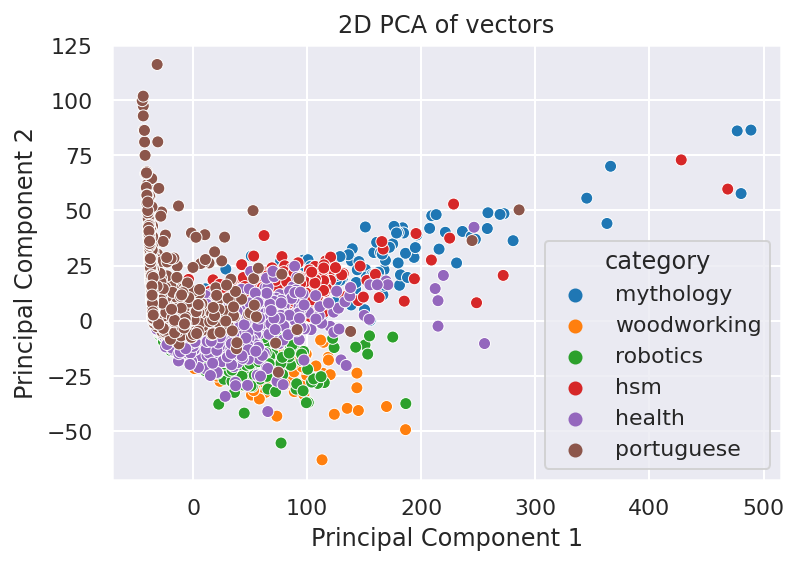

In [36]:
# scatter plot of the points
sns.scatterplot(x=xs_pca[:, 0], y=xs_pca[:, 1], hue=doc_df['category'], legend='full')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of vectors')
plt.grid(True)
plt.show()

## Train models to predict text subjects

### Split the data in training and test sets

In [37]:
train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training (faster).

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time

* (Optional) Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

In [38]:
import time

In [39]:
metrics_df = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1", "training_time"])

In [40]:
# Naive Bayes for category classification
start_time = time.time()
nb_model = naive_bayes.MultinomialNB()
train_pred = nb_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = nb_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["Naive Bayes"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 0.9739990113692536
Test accuracy: 0.976239907727797


In [41]:
# Logistic Regression for category classification
start_time = time.time()
lr_model = linear_model.LogisticRegression(random_state=0)
train_pred = lr_model.fit(train_xs, train_ys)
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
train_time = time.time() - start_time
test_pred = lr_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["Logistic Regression"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 1.0
Test accuracy: 0.9820069204152249


/home/carlos/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
# KNN for category classification
start_time = time.time()
knn_model = neighbors.KNeighborsClassifier(n_neighbors=5)
train_pred = knn_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = knn_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["KNN"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 0.8034602076124567
Test accuracy: 0.6844290657439447


In [43]:
# SVM for category classification and save the training time
start_time = time.time()
svm_model = svm.SVC()
train_pred = svm_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = svm_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["SVM"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 0.9662876915472072
Test accuracy: 0.9462514417531719


In [44]:
# Decision Tree for category classification
start_time = time.time()
dt_model = tree.DecisionTreeClassifier()
train_pred = dt_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = dt_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["Decision Tree"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 1.0
Test accuracy: 0.8722029988465975


In [45]:
# Random Forest for category classification
start_time = time.time()
rf_model = ensemble.RandomForestClassifier()
train_pred = rf_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = rf_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["Random Forest"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 1.0
Test accuracy: 0.9644752018454441


In [46]:
print(metrics_df)

                     accuracy  precision  recall    f1  training_time
Naive Bayes              0.98       0.97    0.97  0.97       5.20e-02
Logistic Regression      0.98       0.98    0.98  0.98       1.41e+01
KNN                      0.68       0.74    0.72  0.70       9.05e-03
SVM                      0.95       0.96    0.94  0.94       1.36e+02
Decision Tree            0.87       0.88    0.87  0.87       9.07e+00
Random Forest            0.96       0.97    0.96  0.96       3.52e+01


In [47]:
# Now using SGDClassifier for category classification with logistic regression (loss="log")
start_time = time.time()
sgd_model = linear_model.SGDClassifier(loss="log_loss")
train_pred = sgd_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = sgd_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["SGDClassifier_LR"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 0.9993079584775086
Test accuracy: 0.9797001153402537


In [48]:
# Now using SGDClassifier for category classification with SVM (loss="hinge")
start_time = time.time()
sgd_model = linear_model.SGDClassifier(loss="hinge")
train_pred = sgd_model.fit(train_xs, train_ys)
train_time = time.time() - start_time
print("Train accuracy:", metrics.accuracy_score(train_ys, train_pred.predict(train_xs)))
test_pred = sgd_model.predict(test_xs)
print("Test accuracy:", metrics.accuracy_score(test_ys, test_pred))
metrics_df.loc["SGDClassifier_SVM"] = [
    metrics.accuracy_score(test_ys, test_pred),
    metrics.precision_score(test_ys, test_pred, average="macro"),
    metrics.recall_score(test_ys, test_pred, average="macro"),
    metrics.f1_score(test_ys, test_pred, average="macro"),
    train_time,
]

Train accuracy: 1.0
Test accuracy: 0.9838523644752019


In [49]:
print(metrics_df)

                     accuracy  precision  recall    f1  training_time
Naive Bayes              0.98       0.97    0.97  0.97       5.20e-02
Logistic Regression      0.98       0.98    0.98  0.98       1.41e+01
KNN                      0.68       0.74    0.72  0.70       9.05e-03
SVM                      0.95       0.96    0.94  0.94       1.36e+02
Decision Tree            0.87       0.88    0.87  0.87       9.07e+00
Random Forest            0.96       0.97    0.96  0.96       3.52e+01
SGDClassifier_LR         0.98       0.98    0.98  0.98       2.10e+00
SGDClassifier_SVM        0.98       0.98    0.98  0.98       1.28e+00


In [ ]:
# performing hyperparameter tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV

parameters = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1],
    "solver": ["liblinear", "lbfgs"],
    "class_weight": ["balanced", None],
}

lr_model = linear_model.LogisticRegression(random_state=0)
clf = GridSearchCV(lr_model, parameters, scoring="accuracy", cv=5, n_jobs=-1)
clf.fit(train_xs, train_ys)
best_stimator = clf.best_estimator_
test_pred = best_stimator.predict(test_xs)

In [51]:
print("Best parameters: " + str(clf.best_params_))
print("Best score obtained: " + str(clf.best_score_))

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best score obtained: 0.9803262481463173


In [53]:
print(metrics.classification_report(test_ys, test_pred, target_names=CORPORA))

              precision    recall  f1-score   support

   mythology       0.97      0.97      0.97       420
 woodworking       0.99      0.99      0.99       692
    robotics       0.99      0.99      0.99       935
         hsm       0.97      0.97      0.97       709
      health       0.98      0.99      0.98      1054
  portuguese       1.00      0.99      0.99       525

    accuracy                           0.98      4335
   macro avg       0.98      0.98      0.98      4335
weighted avg       0.98      0.98      0.98      4335



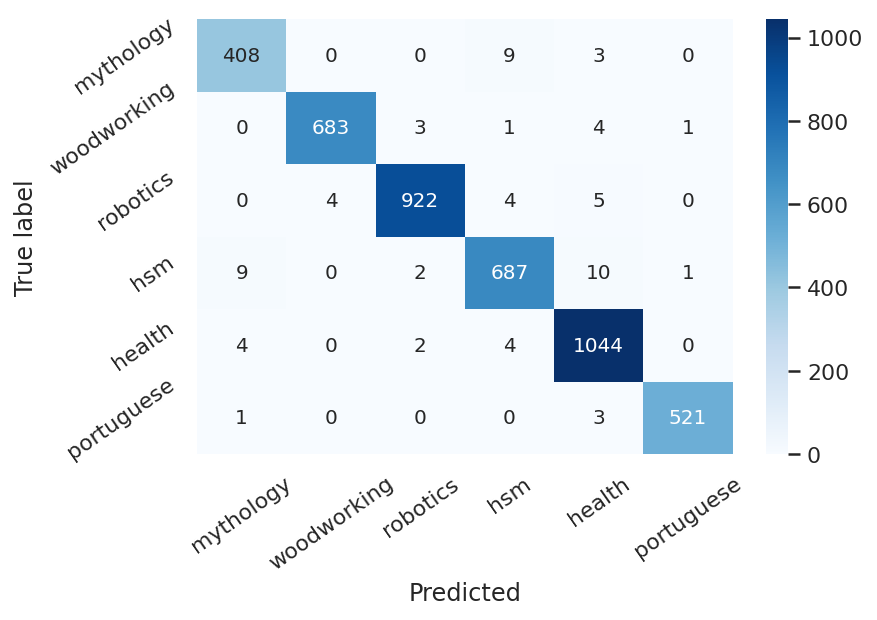

In [54]:
# plot the confusion matrix with seaborn and put the names in each cell
cm = metrics.confusion_matrix(test_ys, test_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CORPORA, yticklabels=CORPORA, cmap="Blues")
plt.xlabel("Predicted")
plt.xticks(rotation=35)
plt.ylabel("True label")
plt.yticks(rotation=35)
plt.show()

### 🚧 TODO: Explain what model seems to work best

____

We consider that the model with the best performance seems to be the **SGDClassifier** with **hinge** loss (i.e the correspondent to SVM). We can say that because this is the one with highest values of accuracy, precision, recall and f1_score beside LogisticRegression ones but with better training time.